In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 3.8 MB/s 
     |████████████████████████████████| 6.6 MB 33.8 MB/s 
     |████████████████████████████████| 895 kB 31.8 MB/s 
     |████████████████████████████████| 77 kB 4.3 MB/s 
     |████████████████████████████████| 596 kB 10.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd, glob, re, string,seaborn as sns
from nltk.corpus import stopwords
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,f1_score,precision_recall_fscore_support,log_loss
from sklearn.linear_model import Lasso, SGDClassifier,LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import keras.backend as K
import tensorflow as tf
from keras import layers, losses
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping,TensorBoard
from sklearn.model_selection import train_test_split,GridSearchCV, LeaveOneOut, KFold,cross_val_score
#import tensorflow_text as text
import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder
l = LabelEncoder()
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from numpy import mean
from matplotlib import pyplot
from tqdm import tqdm
import os
os.system('CUDA_LAUNCH_BLOCKING=1')

from textblob import TextBlob
from textblob import Word
nltk.download('wordnet')
nltk.download('punkt')
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification ,BertTokenizer
from transformers import Trainer, TrainingArguments

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Create DataFrames**

In [ ]:
def clean_text(text,stop_words=True, normalization=True):
    cleaned_text = text.lower()
    cleaned_text = "".join(c for c in cleaned_text if c not in string.punctuation)
    cleaned_text = "".join(c for c in cleaned_text if ord(c)<128)
    words = cleaned_text.split()
    if normalization == True:
      if stop_words==True:
          words = [w for w in words if w not in stopwords.words("english")]
      lem = WordNetLemmatizer()
      words = [lem.lemmatize(word, "v") for word in words]
      words = [lem.lemmatize(word, "n") for word in words]
    cleaned_text = " ".join(words)
    return cleaned_text
def create_dataframe(path):
    train_files = glob.glob(path + "/*.csv")
    df = pd.concat([pd.read_csv(filename, index_col=None, header=0) for filename in train_files], axis=0, ignore_index=True)
    df = df.drop(['Unnamed: 0'],axis=1)
    df = df.drop_duplicates()
    return df

In [ ]:
path = r'/content/drive/My Drive/LegalArguementMining/'
df_train = create_dataframe(path + "Train_data")
df_train,df_untouched = train_test_split(df_train, stratify=df_train['Target'], test_size=0.2)
df_test = create_dataframe(path + "test_data")
df_unlabelled = create_dataframe(path + "Unlabeled_data")
df_train.head()

,Sentence,Target
3449,"Thereupon, a person identified as â€œRoyâ€ ca...",Facts
16481,h. performs an obscene act or otherwise presen...,Rule/Law/Holding
23361,Many of the cases cited relate to searches inc...,Facts
2617,"Defendant Guam Memorial Hospital, (GMH), filed...",Facts
6624,"342, 58 S.W. 2d 1099, are to be construed as c...",Conclusion


In [ ]:
df_train['Target'].unique()

array(['Facts', 'Rule/Law/Holding', 'Conclusion', 'Issue', 'Invalid',
       'Analysis', 'Others'], dtype=object)

In [ ]:
df_test['Target'].unique()

array(['Facts', 'Analysis', 'Rule/Law/Holding', 'Conclusion', 'Invalid',
       'Issue', 'Others'], dtype=object)

In [ ]:
df_untouched.shape,df_train.shape,df_test.shape,df_unlabelled.shape

((887, 2), (3548, 2), (521, 2), (502560, 2))

Analysis on length of all the sentences in the train set

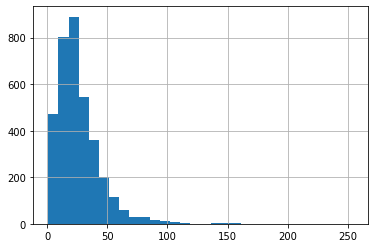

In [ ]:
pd.Series([len(i.split()) for i in df_train['Sentence']]).hist(bins = 30)

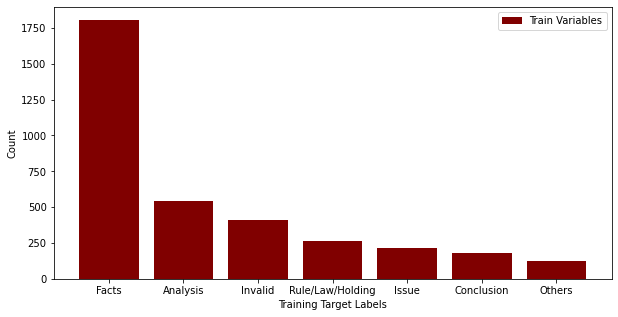

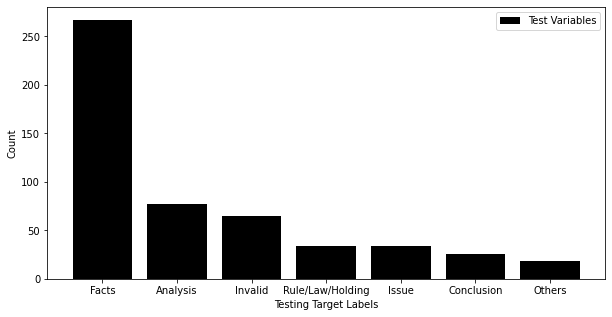

In [ ]:
#plot bar graphs of df_train and df_test
import matplotlib.pyplot as plt  
# creating the dataset 
data = df_train['Target'].value_counts()
keys = list(data.keys()) 
values = list(data.values) 
data1 = df_test['Target'].value_counts()
keys1 = list(data1.keys()) 
values1 = list(data1.values)    
fig = plt.figure(figsize = (10, 5)) 
# creating the bar plot 
plt.bar(keys, values, color ='maroon',label ='Train Variables')  
plt.xlabel("Training Target Labels") 
plt.ylabel("Count") 
plt.legend()
plt.show()
plt.figure(figsize = (10, 5)) 
plt.bar(keys1, values1, color ='black',label ='Test Variables')
plt.xticks(keys)    
plt.xlabel("Testing Target Labels") 
plt.ylabel("Count") 
plt.legend()
plt.show()

**Label Encoding Dependent Variable**

In [ ]:
l = LabelEncoder().fit(df_train['Target'])
df_train['Target'] = l.transform(df_train['Target'])
df_untouched['Target'] = l.transform(df_untouched['Target'])
df_test['Target'] = l.transform(df_test['Target'])
df_train.head()

,Sentence,Target
3449,"Thereupon, a person identified as â€œRoyâ€ ca...",2
16481,h. performs an obscene act or otherwise presen...,6
23361,Many of the cases cited relate to searches inc...,2
2617,"Defendant Guam Memorial Hospital, (GMH), filed...",2
6624,"342, 58 S.W. 2d 1099, are to be construed as c...",1


**Clean Text and no Normalization**

In [ ]:
df_train['Sentence'] = df_train['Sentence'].apply(clean_text, normalization=False)
df_untouched['Sentence'] = df_untouched['Sentence'].apply(clean_text, normalization=False)
df_test['Sentence'] = df_test['Sentence'].apply(clean_text, normalization=False)

**Cleaned and Normalized Text**

In [ ]:
df_train['Normalized_Sentence'] = df_train['Sentence'].apply(clean_text)
df_untouched['Normalized_Sentence'] = df_untouched['Sentence'].apply(clean_text)
df_test['Normalized_Sentence'] = df_test['Sentence'].apply(clean_text)

1. Word Embedding with Tf-Idf
2. Word Embedding with Word2Vec
3. Word Embedding with BERT

**Word Embedding with Tf-Idf**

In [ ]:
def data2tfidf(data1,data2,data3,pca=False):
  data = pd.concat([data1,data2,data3],axis=0)
  t= TfidfVectorizer().fit(data['Normalized_Sentence'])
  x = t.transform(data['Normalized_Sentence']).toarray()
  train_x, test_x, untouched_x = t.transform(data1['Normalized_Sentence']).toarray(), t.transform(data2['Normalized_Sentence']).toarray(), t.transform(data3['Normalized_Sentence']).toarray()
  train_y, test_y, untouched_y = data1['Target'], data2['Target'], data3['Target']
  if pca:
    pcas = PCA(500).fit(x)
    train_x, test_x, untouched_x = pcas.transform(train_x), pcas.transform(test_x), pcas.transform(untouched_x)
  return train_x,train_y,test_x,test_y, untouched_x, untouched_y

train_x,train_y,test_x,test_y, untouched_x, untouched_y = data2tfidf(df_train,df_test,df_untouched,pca=False)
train_x.shape,train_y.shape,test_x.shape,test_y.shape,untouched_x.shape, untouched_y.shape

((3548, 5973), (3548,), (521, 5973), (521,), (887, 5973), (887,))

1. Logistic Regression
2. Decision Trees
3. Random Forests
4. Gradient Boosting
5. XGBoosting
6. Light Boosting
7. Ada Boosting
8. Ridge Classification

In [ ]:
def get_models(a=0,b=None):
    models = [RandomForestClassifier(),XGBClassifier(),LGBMClassifier()]
    train_accuracy,untouched_accuracy,test_accuracy = [], [], []
    if not b:
      b=len(models)
    l = models[a:b]
    for m in tqdm(l):
        m.fit(train_x, train_y)
        train_accuracy.append(accuracy_score(train_y,m.predict(train_x)))
        untouched_accuracy.append(accuracy_score(untouched_y,m.predict(untouched_x)))
        test_accuracy.append(accuracy_score(test_y,m.predict(test_x)))
    data = pd.DataFrame({'Model':[str(i)[:-2] for i in l],'Training Accuracy':train_accuracy,'Testing Accuracy':test_accuracy,'Untouched Accuracy':untouched_accuracy})
    return data
get_models()

100%|██████████| 3/3 [05:15<00:00, 105.25s/it]


,Model,Training Accuracy,Testing Accuracy,Untouched Accuracy
0,RandomForestClassifier,0.992390,0.631478,0.608794
1,XGBClassifier(objective='multi:softprob,0.669673,0.589251,0.593010
2,LGBMClassifier,0.881060,0.654511,0.618940


In [ ]:
parameter_grid = {'learning_rate' : [ 0.0001,0.001,0.01,0.1,1,10]}
lgbm= LGBMClassifier(n_estimators = 1000)
cv = KFold(n_splits=10, shuffle=True, random_state=101)
gridsearch = GridSearchCV(estimator=lgbm, param_grid=parameter_grid, scoring='accuracy', cv=cv)
gridsearch.fit(train_x,train_y)
m = gridsearch.best_estimator_
print(m)
m.fit(train_x,train_y)
print('Training Accuracy is',accuracy_score(train_y,m.predict(train_x)))
print('Untouched Accuracy is',accuracy_score(untouched_y,m.predict(untouched_x)))
print('Testing Accuracy is',accuracy_score(test_y,m.predict(test_x)))

LGBMClassifier(learning_rate=0.01, n_estimators=1000)
Training Accuracy is 0.87880496054115
Untouched Accuracy is 0.6133032694475761
Testing Accuracy is 0.6238003838771593


Co-Training

In [ ]:
#Co-training Algorithm
from sklearn.utils import resample
import math, numpy as np
import glob
def create_dataframe(path):
        train_files = glob.glob(path + "/*.csv")
        df = pd.concat([pd.read_csv(filename, index_col=None, header=0) for filename in train_files], axis=0, ignore_index=True)
        df = df.drop(['Unnamed: 0'],axis=1)
        return df
train = create_dataframe('/content/drive/My Drive/LegalArguementMining/' + "Train_data")
train.sort_values("Sentence", inplace = True)
train = train.drop_duplicates(subset ="Sentence")
train['Target'].unique()
train['Target']=train['Target'].replace(['Others'],'Invalid')
train['Target'].unique()
print(len(train))
train = train.rename(columns={'Sentence':'text'})
test = pd.read_csv(r'/content/drive/My Drive/LegalArguementMining/test_data/test_data.csv')
unlabelled = pd.read_csv(r'/content/drive/My Drive/LegalArguementMining/Unlabeled_data/Unlabeled_data.csv')
class CoTraining():
  def perform(self,train,test,unlabelled):
    self.test = test
    record_unlabel_list = []
    record_f1_score = []
    record_CR = []
    def training(unlabel_1,train,i,j):
        train_size = len(train)
        record_unlabel_list.append(train_size - 4416)
        target_values = np.unique(train['Target'].values)
        data_list = []
        data_length_list = []
        for i in target_values:
          df_k = train[train['Target']==i]
          data_list.append(df_k)
          data_length_list.append(len(df_k))
        maximum_data = max(data_length_list)
        print("maximum_data",maximum_data)
        ratio = math.floor(( 4 / 6 )* maximum_data)
        print("ratio",ratio)
        loop_count = 0
        train_upsampled = []
        for i in data_length_list:
          if i < ratio:
            df_upsampled = resample(data_list[loop_count],replace=True,n_samples=ratio,random_state=123)
          else:
            df_upsampled = resample(data_list[loop_count],replace=True,n_samples=i,random_state=123)
          print("@",len(df_upsampled))
          train_upsampled.append(df_upsampled)
          loop_count = loop_count + 1
        df_res = pd.concat(train_upsampled)
        train = df_res.copy(deep = True)
        print("len of train $$$",len(train))
        i_list.append(i)
        j_list.append(j)
        print("length of the UL received",len(unlabel_1))
        #cleaning
        nltk.download('stopwords')
        nltk.download('wordnet')
        stopword=nltk.corpus.stopwords.words('english')
        wl= WordNetLemmatizer()
        def clean_text(text):
          text="".join([word.lower() for word in text if word not in string.punctuation])
          tokens = re.split('\W+',text)
          text = [wl.lemmatize(word) for word in tokens if word not in stopword]
          return text
        tfidf_vect = TfidfVectorizer(analyzer = clean_text)
        X_tfidf = tfidf_vect.fit_transform(train['text'])
        print(X_tfidf.shape)
        #Read the test data
        test = self.test
        test['Target']=test['Target'].replace(['Others'],'Invalid')
        test['Sentence'] = test['Sentence'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
        test['Sentence'] = test['Sentence'].str.replace('[^\w\s]','')
        words = stopwords.words('english')
        test['Sentence'] = test['Sentence'].apply(lambda x: " ".join(x for x in x.split() if x not in words))
        t_p = tfidf_vect.transform(test['Sentence'])
        classifier_rf = RandomForestClassifier(n_estimators = 350, criterion = 'gini', max_features = 'auto', random_state = 42)
        classifier_lgb = LGBMClassifier()
        classifier_svm = LinearSVC(multi_class='ovr',class_weight='balanced')
        X_train, x_val, Y_train, y_val = train_test_split(X_tfidf,train['Target'],test_size=0.20,random_state=42)
        X_train_whole = X_tfidf
        Y_train_whole = train['Target']
        classifier_rf.fit(X_train, Y_train)
        classifier_lgb.fit(X_train, Y_train)
        classifier_svm.fit(X_train, Y_train)
        val_pred_rf = classifier_rf.predict(x_val)
        val_pred_lgb = classifier_lgb.predict(x_val)
        val_pred_svm = classifier_svm.predict(x_val)
        Accuracy_score_rf = accuracy_score(y_val,val_pred_rf)
        print("Accuracy_score_rf ",Accuracy_score_rf)
        Accuracy_score_lgb = accuracy_score(y_val,val_pred_lgb)
        print("Accuracy_score_lgb ",Accuracy_score_lgb)
        Accuracy_score_svm = accuracy_score(y_val,val_pred_svm)
        print("Accuracy_score_svm ",Accuracy_score_svm)
        if (Accuracy_score_rf > Accuracy_score_lgb) and (Accuracy_score_rf > Accuracy_score_svm):
          B = classifier_rf
        elif (Accuracy_score_svm > Accuracy_score_lgb) and (Accuracy_score_svm > Accuracy_score_rf):
          B = classifier_svm
        else:
          B = classifier_lgb
        B.fit(X_train_whole,Y_train_whole)
        print("len of train tfid #####",len(Y_train_whole))
        test_pred = B.predict(t_p)
        accuracy_test = accuracy_score(test['Target'],test_pred)
        print('Accuracy test data', accuracy_test)
        classification_report_test_data = classification_report(test['Target'],test_pred)
        record_CR.append(classification_report_test_data)
        print("classification report ",classification_report_test_data)
        class_x_un1 = tfidf_vect.transform(unlabel_1['text'])
        class_pred_unlabel_1 = B.predict(class_x_un1)
        unlabel_1['Target']=class_pred_unlabel_1
        frame_1 = [train,unlabel_1]
        train_1 = pd.concat(frame_1)   
        return train_1,accuracy_test
    #Read the unlabeled data
    unlabel = unlabelled
    unlabel.head()

    del unlabel['Complete']
    del unlabel['Unnamed: 0']

    unlabel['text'] = unlabel['text'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
    unlabel['text'] = unlabel['text'].str.replace('[^\w\s]','')
    words = stopwords.words('english')
    unlabel['text'] = unlabel['text'].apply(lambda x: " ".join(x for x in x.split() if x not in words))
    unlabel['text'] = unlabel['text'].apply(lambda x: TextBlob(x).words)
    unlabel['text'] = unlabel['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x]))

    all_Data_train_size = len(train)
    length_list = [500]

    j=0
    iteration = 0
    i_list = []
    j_list = []
    f1_score_test_list = []
    train_size_list =[]

    for i in length_list:
      print("iteration ",iteration)
      print(i)
      print(j)
      unlabel_chunk = unlabel[j:i]
      train,accuracy_test = training(unlabel_chunk,train,i,j)
      j=i
      iteration = iteration + 1
      print("length",len(unlabel_chunk))
      return accuracy_test
CoTraining().perform(train,test,unlabelled)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4416


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: FutureWarning: The default value of regex will change from True to False in a future version.


iteration  0
500
0
maximum_data 2253
ratio 1502
@ 1502
@ 1502
@ 2253
@ 1502
@ 1502
@ 1502
len of train $$$ 9763
length of the UL received 500
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
(9763, 6515)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: FutureWarning: The default value of regex will change from True to False in a future version.


Accuracy_score_rf  0.9482846902201741
Accuracy_score_lgb  0.8965693804403482
Accuracy_score_svm  0.9339477726574501
len of train tfid ##### 9763
Accuracy test data 0.6353166986564299
classification report                    precision    recall  f1-score   support

        Analysis       0.48      0.31      0.38        77
      Conclusion       0.70      0.73      0.72        26
           Facts       0.72      0.78      0.75       267
         Invalid       0.44      0.57      0.49        83
           Issue       0.89      0.50      0.64        34
Rule/Law/Holding       0.57      0.47      0.52        34

        accuracy                           0.64       521
       macro avg       0.63      0.56      0.58       521
    weighted avg       0.64      0.64      0.63       521

length 500


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.6353166986564299

Psuedo Labeling

In [ ]:
import glob
from textblob import TextBlob
from textblob import Word
def create_dataframe(path):
    train_files = glob.glob(path + "/*.csv")
    df = pd.concat([pd.read_csv(filename, index_col=None, header=0) for filename in train_files], axis=0, ignore_index=True)
    df = df.drop(['Unnamed: 0'],axis=1)
    return df
train = create_dataframe('/content/drive/My Drive/LegalArguementMining/' + "Train_data")

train.sort_values("Sentence", inplace = True)


train = train.drop_duplicates(subset ="Sentence")

train['Target'].unique()

train['Target']=train['Target'].replace(['Others'],'Invalid')
train['Target'].unique()
test = pd.read_csv(r'/content/drive/My Drive/LegalArguementMining/test_data/test_data.csv')
unlabelled = pd.read_csv(r'/content/drive/My Drive/LegalArguementMining/Unlabeled_data/Unlabeled_data.csv')
class PseudoLabelling():
  def perform(self,train,test,unlabelled):
    wl= WordNetLemmatizer()
    #cleaning data
    def clean_text(text):
      text="".join([word.lower() for word in text if word not in string.punctuation])
      tokens = re.split('\W+',text)
      text = [wl.lemmatize(word) for word in tokens if word not in stopword]
      return text

    tfidf_vect = TfidfVectorizer(analyzer = clean_text)
    X_tfidf = tfidf_vect.fit_transform(train['Sentence'])

    #reading the test data
    test = test
    X_train, x_val, Y_train, y_val = train_test_split(X_tfidf,train['Target'],test_size=0.20,random_state=42)
    #Initialize the classifier
    classifier = LGBMClassifier()
    classifier.fit(X_train, Y_train)
    #Unlabel data preprocessing
    unlabel = unlabelled
    #unlabel.head()

    del unlabel['Complete']
    del unlabel['Unnamed: 0']

    unlabel['text'] = unlabel['text'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
    unlabel['text'] = unlabel['text'].str.replace('[^\w\s]','')
    words = stopwords.words('english')
    unlabel['text'] = unlabel['text'].apply(lambda x: " ".join(x for x in x.split() if x not in words))

    
    nltk.download('wordnet')
    nltk.download('punkt')
    unlabel['text'] = unlabel['text'].apply(lambda x: TextBlob(x).words)
    unlabel['text'] = unlabel['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x]))

    def index_reset(unlabel_2):
      unlabel_2.reset_index(inplace=True)
      del unlabel_2['index']
      return unlabel_2
    unlabel_size_list = [500,1000]
    #unlabel_size = 500 #comment
    Threshold = 0.9 # comment
    train = train.rename(columns={'Sentence':'text'})
    record_unlabel_size_list = []
    record_concat_train_size_list = []
    record_upsample_size = []
    record_cross_f1 = [] 
    record_cross_accuracy = []
    record_SS_CR = []
    record_SS_F1 = []
    accuracy = []
    #looping through the unlabel data
    for unlabel_size in unlabel_size_list:
      record_unlabel_size_list.append(unlabel_size)
      unlabel_1 = unlabel.loc[:unlabel_size]
      unlabel_1 = index_reset(unlabel_1)
      tfidf_vect = TfidfVectorizer(analyzer = clean_text)
      X_tfidf = tfidf_vect.fit_transform(train['text'])
      x_un1 = tfidf_vect.transform(unlabel_1['text'])
      print(x_un1.shape)
      pred_unlabel_1 = classifier.predict_proba(x_un1)
      pred_unlabel_1
      x_un1.shape
      pos=[]
      large=[]
      ind = []
      i=0
      for j in pred_unlabel_1:
        if max(j)> Threshold:
          ind.append(np.argmax(j))
          large.append(max(j))
          pos.append(i)
        i+=1
      unlabel_1 = unlabel_1.loc[pos,:]
      train_data_size = len(unlabel_1)
      class_x_un1 = tfidf_vect.transform(unlabel_1['text'])
      class_x_un1.shape
      class_pred_unlabel_1 = classifier.predict(class_x_un1)
      class_pred_unlabel_1
      unlabel_1['Target']=class_pred_unlabel_1
      train = train.rename(columns={'Sentence':'text'})
      frame_1 = [train,unlabel_1]
      train_1 = pd.concat(frame_1)
      record_concat_train_size_list.append(len(train_1))
      target_values = np.unique(train_1['Target'].values)
      data_list = []
      data_length_list = []
      for i in target_values:
        df_k = train_1[train_1['Target']==i]
        data_list.append(df_k)
        data_length_list.append(len(df_k))
      maximum_data = max(data_length_list)
      ratio = math.floor(( 4 / 6 )* maximum_data)
      loop_count = 0
      train_upsampled = []
      for i in data_length_list:
        if i < ratio:
          df_upsampled = resample(data_list[loop_count],replace=True,n_samples=ratio,random_state=123)
        else:
          df_upsampled = resample(data_list[loop_count],replace=True,n_samples=i,random_state=123)
        train_upsampled.append(df_upsampled)
        loop_count = loop_count + 1
      df_res = pd.concat(train_upsampled)
      record_upsample_size.append(len(df_res))
      tfidf_vect = TfidfVectorizer(analyzer = clean_text)
      X_tfidf = tfidf_vect.fit_transform(df_res['text'])
      X_tfidf_df=pd.DataFrame(X_tfidf.toarray())
      X_tfidf_df.columns=tfidf_vect.get_feature_names()
      X_train, x_val, Y_train, y_val = train_test_split(X_tfidf,df_res['Target'],test_size=0.20,random_state=42)
      classifier_1 = LGBMClassifier()
      classifier_1.fit(X_train, Y_train)
      y_pred = classifier_1.predict(x_val)
      Accuracy_score = accuracy_score(y_val, y_pred)
      cv = KFold(n_splits=5, random_state=1, shuffle=True)
      scores_acc = cross_val_score(classifier_1,x_val ,y_val, scoring = 'accuracy', cv=cv, n_jobs=-1).mean()
      record_cross_accuracy.append(scores_acc)
      test['Target']=test['Target'].replace(['Others'],'Invalid')
      test['Sentence'] = test['Sentence'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
      test['Sentence'] = test['Sentence'].str.replace('[^\w\s]','')
      words = stopwords.words('english')
      test['Sentence'] = test['Sentence'].apply(lambda x: " ".join(x for x in x.split() if x not in words))
      t_p = tfidf_vect.transform(test['Sentence'])
      test_pred = classifier_1.predict(t_p)
      classification_report_semi_supervised = classification_report(test['Target'],test_pred, digits=4)
      record_SS_CR.append(classification_report_semi_supervised)
      f1_Score_metric = f1_score(test['Target'],test_pred,average='weighted')
      record_SS_F1.append(f1_Score_metric)
      accuracy.append(accuracy_score(test['Target'],test_pred))
    return accuracy
PseudoLabelling().perform(train,test,unlabelled)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: FutureWarning: The default value of regex will change from True to False in a future version.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
(501, 7374)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: FutureWarning: The default value of regex will change from True to False in a future version.


(1001, 7374)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: FutureWarning: The default value of regex will change from True to False in a future version.


[0.6065259117082533, 0.581573896353167]

EM-

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import f1_score
import math
from sklearn.utils import resample
drive.mount('/content/drive')

#Read the labeled data
'''train1 = pd.read_csv('/content/drive/My Drive/Research/train_data1.csv')
train2 = pd.read_csv('/content/drive/My Drive/Research/train_data2.csv')
train3 = pd.read_csv('/content/drive/My Drive/Research/train_data3.csv')
train4 = pd.read_csv('/content/drive/My Drive/Research/train_data4.csv')
train5 = pd.read_csv('/content/drive/My Drive/Research/train_data5.csv')
train6 = pd.read_csv('/content/drive/My Drive/Research/train_data6.csv')
train7 = pd.read_csv('/content/drive/My Drive/Research/train_data7.csv')
train8 = pd.read_csv('/content/drive/My Drive/Research/train_data8.csv')
train9 = pd.read_csv('/content/drive/My Drive/Research/train_data9.csv')
train10 = pd.read_csv('/content/drive/My Drive/Research/train_data10.csv')
train_highKappa = pd.read_csv('/content/drive/My Drive/Research/train_data_highkappa.csv')
train = train1
train_list = [train2,train3,train4,train5,train6,train7,train8,train9,train10,train_highKappa]
for i in train_list:
  train = train.append(i)'''

import glob
def create_dataframe(path):
    train_files = glob.glob(path + "/*.csv")
    df = pd.concat([pd.read_csv(filename, index_col=None, header=0) for filename in train_files], axis=0, ignore_index=True)
    df = df.drop(['Unnamed: 0'],axis=1)
    return df
train = create_dataframe('/content/drive/My Drive/LegalArguementMining/' + "Train_data")

train.sort_values("Sentence", inplace = True)
new_train = train.drop_duplicates(subset ="Sentence")
train = new_train
#train['Target'].unique()
train['Target']=train['Target'].replace(['Others'],'Invalid')
#train['Target'].unique()
test = pd.read_csv(r'/content/drive/My Drive/LegalArguementMining/test_data/test_data.csv')
unlabelled = pd.read_csv(r'/content/drive/My Drive/LegalArguementMining/Unlabeled_data/Unlabeled_data.csv')

#cleaning
import nltk
import re
import string
nltk.download('stopwords')
nltk.download('wordnet')
stopword=nltk.corpus.stopwords.words('english')
from nltk.stem import WordNetLemmatizer
wl= WordNetLemmatizer()
class EMLightGBM():
  def perform(self,train,test,unlabelled):
    def clean_text(text):
      text="".join([word.lower() for word in text if word not in string.punctuation])
      tokens = re.split('\W+',text)
      text = [wl.lemmatize(word) for word in tokens if word not in stopword]
      return text
    #len(train['Sentence'])
    text = clean_text(train['Sentence'])
    tfidf_vect = TfidfVectorizer(analyzer = clean_text)
    X_tfidf = tfidf_vect.fit_transform(train['Sentence'])
    print(X_tfidf.shape)
    #Read the test data
    test = test
    test['Target']=test['Target'].replace(['Others'],'Invalid')
    test['Sentence'] = test['Sentence'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
    test['Sentence'] = test['Sentence'].str.replace('[^\w\s]','')
    from nltk.corpus import stopwords
    words = stopwords.words('english')
    test['Sentence'] = test['Sentence'].apply(lambda x: " ".join(x for x in x.split() if x not in words))
    t_p = tfidf_vect.transform(test['Sentence'])
    #Read the unlabeled data
    unlabel = unlabelled
    del unlabel['Complete']
    del unlabel['Unnamed: 0']

    unlabel['text'] = unlabel['text'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
    unlabel['text'] = unlabel['text'].str.replace('[^\w\s]','')
    from nltk.corpus import stopwords
    words = stopwords.words('english')
    unlabel['text'] = unlabel['text'].apply(lambda x: " ".join(x for x in x.split() if x not in words))

    from textblob import TextBlob
    from textblob import Word
    nltk.download('wordnet')
    nltk.download('punkt')
    unlabel['text'] = unlabel['text'].apply(lambda x: TextBlob(x).words)
    unlabel['text'] = unlabel['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x]))

    def index_reset(unlabel_2):
      unlabel_2.reset_index(inplace=True)
      del unlabel_2['index']
      return unlabel_2
    def feature_set_selection(train_and_unlabel_words_wo_duplicates,train_words,unlabel_words):
      for term in train_and_unlabel_words_wo_duplicates:
        freq_train = train_words.count(term) / len(train_words)
        freq_unlabel = unlabel_words.count(term) / len(unlabel_words)
        if freq_unlabel == 0:
          PF.append(term)
        elif (freq_train // freq_unlabel) > Threshold_feature:
          PF.append(term)
        else:
          NF.append(term)

    #Identifying  a  set  of  reliable  negative  documents from the unlabeled set
    def RN_selection(RN, unlabel_1):
      iteration_RN = 0
      RN_to_be_removed = []
      pos_to_be_removed = []
      freq_each_word_list = []
      Q_pos = []
      count = 0
      if_count = 0
      for doc in unlabel_1['text']:
        doc_words = clean_text(doc)
        doc_words_wo_duplicates = list(set(doc_words))
        for_count = 0
        
        for each_doc_word in doc_words_wo_duplicates:
          for_count = for_count + 1
          freq_each_doc_word = doc_words.count(each_doc_word)
          freq_each_word_list.append(freq_each_doc_word)
          if (freq_each_doc_word > 0) and (each_doc_word in PF):
            if_count = if_count + 1
            pos_to_be_removed.append(count)
            RN_to_be_removed.append(doc)
            break
          
        if for_count == len(doc_words_wo_duplicates):
          Q_pos.append(count)
        count = count + 1
        iteration_RN = iteration_RN + 1
      RN.drop(pos_to_be_removed,axis=0,inplace=True)
      return RN,pos_to_be_removed, Q_pos, if_count


    def classifier_select(train, Q, RN):
      f1_score_list = []
      per_CR_list = []
      loop_variable =0
      while(1):
        p_and_RN = pd.concat([train,RN])
        p_and_RN.reset_index(inplace=True,drop=True)
        p_and_RN_vect = tfidf_vect.transform(p_and_RN['text'])
        p_and_RN_vect_df=pd.DataFrame(p_and_RN_vect.toarray())

        Q_vect = tfidf_vect.transform(Q['text'])
        Q_vect_df=pd.DataFrame(Q_vect.toarray())

        lgb_classifier = lgb.LGBMClassifier()
        lgb_classifier.fit(p_and_RN_vect_df, p_and_RN['Target'])
        np.unique(p_and_RN['Target'])

        #checking the classifier if it gives best results
        train_vect = tfidf_vect.transform(train['text'])
        train_vect_df=pd.DataFrame(train_vect.toarray())
        train_pred = lgb_classifier.predict(train_vect_df)
        classified_negative = (train_pred.tolist()).count(-1)
        percentage = (classified_negative / len(train_pred)) * 100
        model_list.append(lgb_classifier)
        if percentage < percent_thresh:
          thresh_model_list.append(lgb_classifier)
          test_pred = lgb_classifier.predict(t_p.toarray())
          test['Target']= LabelEncoder().fit_transform(test['Target'])
          classification_report_test = classification_report(test['Target'],test_pred,digits=4)
          f1_score_test = f1_score(test['Target'],test_pred,average='weighted')
          f1_score_list.append(f1_score_test)
          per_CR_list.append(classification_report_test)
        Q_pred = lgb_classifier.predict(Q_vect_df)
        np.unique(Q_pred)
        count_q = 0
        total_q = 0 
        out_pos_q = []
        pos_q = []
        for i in Q_pred:
          if i == -1:
            pos_q.append(count_q)
            total_q = total_q + 1
          else:
            out_pos_q.append(count_q)
          count_q = count_q + 1
        Q.reset_index(inplace=True,drop=True)
        W = Q.loc[pos_q,:]
        if W.empty :
          #print("W is empty, came out of loop")
          break
        else:
          Q_new = Q.loc[out_pos_q,:]
          Q = Q_new.copy(deep =True)
          RN = pd.concat([RN,W])
          RN.reset_index(inplace=True,drop=True)
          loop_variable = loop_variable + 1
        #print("completed iteration")
      result_dict['F1_score'].append(f1_score_list)
      result_dict['CR'].append(per_CR_list)
      return lgb_classifier, model_list , thresh_model_list
    model_list = []
    thresh_model_list = []
    UL_size_list = []
    result_dict = {"F1_score":[],"CR":[],"Unlabel_size":[]}
    Threshold_feature = 1
    percent_thresh = 5
    unlabel_range = [5000]

    for size in unlabel_range:
      unlabel_1 = unlabel.loc[:size]
      unlabel_1 = index_reset(unlabel_1)
      unlabel_1_copy = unlabel_1.copy(deep = True)
      x_un1 = tfidf_vect.transform(unlabel_1['text'])
      PF = []
      NF = []
      unlabel_1['Target']=-1
      train = train.rename(columns={'Sentence':'text'})
      train['Target']= LabelEncoder().fit_transform(train['Target'])
      train_and_unlabel =  pd.concat([train,unlabel_1])
      #print(len(train))
      #print(len(unlabel_1))
      #print(len(train_and_unlabel))

      train = train.rename(columns={'Sentence':'text'})
      #mixed sampling
      train_and_unlabel =  pd.concat([train,unlabel_1])
      #print("len of train_and_unlabel",len(train_and_unlabel))
      train_and_unlabel.reset_index(inplace=True)
      del train_and_unlabel['index']
      target_values = np.unique(train_and_unlabel['Target'].values)
      data_list = []
      data_length_list = []
      for i in target_values:
        df_k = train_and_unlabel[train_and_unlabel['Target']==i]
        data_list.append(df_k)
        data_length_list.append(len(df_k))
      maximum_data = max(data_length_list)
      ratio = math.floor(( 4 / 6 )* maximum_data)
      loop_count = 0
      train_upsampled = []
      for i in data_length_list:
        if i < ratio:
          df_upsampled = resample(data_list[loop_count],replace=True,n_samples=ratio,random_state=123)
        else:
          df_upsampled = resample(data_list[loop_count],replace=True,n_samples=i,random_state=123)
        train_upsampled.append(df_upsampled)
        loop_count = loop_count + 1

      df_res = pd.concat(train_upsampled)
      train_and_unlabel = df_res.copy(deep = True)
      #print("len of train_and_unlabel",len(train_and_unlabel))
      train['Target']= LabelEncoder().fit_transform(train['Target'])
      train_and_unlabel_words = clean_text(train_and_unlabel['text'])
      train_and_unlabel_words_wo_duplicates = list(set(train_and_unlabel_words))
      train_words = clean_text(train['text'])
      train_words_wo_duplicates = list(set(train_words))
      unlabel_words = clean_text(unlabel_1['text'])
      unlabel_words_wo_duplicates = list(set(unlabel_words))
      feature_set_selection(train_and_unlabel_words_wo_duplicates,train_words,unlabel_words)
      RN = unlabel_1.copy(deep=True) 
      RN,op_pos_to_be_removed, op_Q_pos, op_if_count = RN_selection(RN,unlabel_1) 
      Q =  unlabel_1.loc[op_pos_to_be_removed,:]
      result_dict['Unlabel_size'].append(size) 
      lgb_classifier, op_model_list, op_thresh_model_list = classifier_select(train, Q, RN)
    for model in op_model_list:
      test_pred = model.predict(t_p.toarray())
      test['Target']= LabelEncoder().fit_transform(test['Target'])
      classification_report_test = classification_report(test['Target'],test_pred,digits=4)
      print(accuracy_score(test['Target'],test_pred))
    for model in op_thresh_model_list:
      test_pred = model.predict(t_p.toarray())
      test['Target']= LabelEncoder().fit_transform(test['Target'])
      classification_report_test = classification_report(test['Target'],test_pred,digits=4)
      print(accuracy_score(test['Target'],test_pred))
    return accuracy_score(test['Target'],test_pred)

EMLightGBM().perform(train,test,unlabelled)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
(4416, 7374)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: FutureWarning: The default value of regex will change from True to False in a future version.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/s

0.46833013435700577
0.42034548944337813
0.39923224568138194


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

0.3838771593090211
0.3857965451055662
0.3742802303262956


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

0.3646833013435701
0.3685220729366603
0.3685220729366603


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

0.3723608445297505
0.3685220729366603
0.3666026871401152


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

0.35892514395393477
0.3570057581573896
0.3723608445297505


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

0.362763915547025
0.362763915547025
0.362763915547025


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

0.35892514395393477
0.36084452975047987
0.362763915547025
0.36084452975047987


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.36084452975047987

BERT + Fine - Tuning

In [ ]:
import random, numpy as np
import glob
def create_dataframe(path):
    train_files = glob.glob(path + "/*.csv")
    df = pd.concat([pd.read_csv(filename, index_col=None, header=0) for filename in train_files], axis=0, ignore_index=True)
    df = df.drop(['Unnamed: 0'],axis=1)
    df = df.drop_duplicates()
    return df
path = r'/content/drive/My Drive/LegalArguementMining/'
df_train = create_dataframe(path + "Train_data")
df_train,df_untouched = train_test_split(df_train, stratify=df_train['Target'], test_size=0.2)
df_test = create_dataframe(path + "test_data")
df_unlabelled = create_dataframe(path + "Unlabeled_data")
from sklearn.preprocessing import LabelEncoder

l = LabelEncoder().fit(df_train['Target'])
df_train['Target'] = l.transform(df_train['Target'])
df_untouched['Target'] = l.transform(df_untouched['Target'])
df_test['Target'] = l.transform(df_test['Target'])

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf
        tf.random.set_seed(seed)
set_seed(1)
max_length = 512
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", do_lower_case=True)
train_texts , train_labels = df_train['Sentence'], df_train['Target']
valid_texts, valid_labels = df_test['Sentence'], df_test['Target']
test_texts, test_labels = df_untouched['Sentence'], df_untouched['Target']
target_names = df_train['Target'].value_counts().keys().tolist()

train_encodings = tokenizer(train_texts.to_list(), truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts.to_list(), truncation=True, padding=True, max_length=max_length)
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = NewsGroupsDataset(train_encodings, train_labels.to_list())
valid_dataset = NewsGroupsDataset(valid_encodings, valid_labels.to_list())
model_name = '/content/drive/My Drive/LegalArguementMining/BertLegal'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names)).to("cuda")
from sklearn.metrics import accuracy_score
def get_prediction(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    return target_names[probs.argmax()], probs.argmax().cpu().numpy()

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
pred = [get_prediction(i)[1] for i in df_test.Sentence.values.tolist()]
print('Accuracy of Test Dataset :',accuracy_score(pred, df_test.Target.values.tolist()))

Accuracy of Test Dataset : 0.727447216890595
